In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
import sklearn as sk
import pickle

In [2]:
# Create a custom function for data transformation
# May as well import all of these features into the initial dataframe, you can cut it down..
# ..when you do the X,y train/test split
features = ['datetime',
            'latitude',
            'longitude',
            'absoluteAltitude',
            'magneticHeading',
            'trueHeading',
            'groundSpeed',
            'trueAirspeed',
            'pitch',
            'roll',
            'yaw',
            'angleOfAttack',
            'flightPathAngle',
            'verticalFlightPathAngle',
            'horizontalFlightPathAngle',
            'rollAcceleration',
            'pitchAcceleration',
            'yawAcceleration',
            'e1N1ng',
            'e2N1ng',
            'e1N2nf',
            'e2N2nf',
            'mainRotorRpm',
            'tailRotorRpm',
            'mainRotorTorque',
            'e1Itt',
            'e2Itt',
            'mainRotorInducedInflow',
            'flightDirectorPitch',
            'flightDirectorRoll',
            'climbOrDescentRate',
            'hasWeightOnWheels',
            'turnRate to degPerSec',
            'cyclicPositionPitch',
            'cyclicPositionRoll',
            'collectivePosition',
            'antiTorquePedalPosition',
            'throttlePosition',
            'e1Torque',
            'e2Torque'
           ]

In [3]:
def df_transformation(df):
    df_temp = df[features]
    df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')

    output = df_temp.groupby(by=["datetime"], dropna=False).mean().reset_index()
    
    return output 

In [4]:
# reading validation files - 10/20 data contains hover and quick stop maneuvers, 10/27 data contains surface taxis
v_df8 = pd.read_csv('SimData_2022.10.20_17.19.15.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# v_df8 = df_transformation(v_df8)

v_df9 = v_df8.copy()

v_df10 = pd.read_csv('SimData_2022.10.27_17.55.06.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# v_df10 = df_transformation(v_df10)


In [5]:
#Add columns for Quick Stop, Hover Taxi, and Surface Taxi
v_df8['Quick_Stop'] = 0
v_df9['Hover_Taxi'] = 0
v_df10['Surface_Taxi'] = 0

#label data points
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:23:30' , '2022-10-20 21:23:54' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:24:55' , '2022-10-20 21:25:20' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:26:20' , '2022-10-20 21:26:46' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:27:47' , '2022-10-20 21:28:05' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:29:33' , '2022-10-20 21:29:56' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:30:50' , '2022-10-20 21:31:12' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:32:20' , '2022-10-20 21:32:40' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:33:55' , '2022-10-20 21:34:18' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:35:20' , '2022-10-20 21:35:45' , inclusive='both')),['Quick_Stop']] = 1
v_df8.loc[(v_df8['datetime'].between('2022-10-20 21:36:45' , '2022-10-20 21:37:11' , inclusive='both')),['Quick_Stop']] = 1

v_df9.loc[(v_df9['datetime'].between('2022-10-20 21:42:00' , '2022-10-20 21:46:30' , inclusive='both')),['Hover_Taxi']] = 1
v_df9.loc[(v_df9['datetime'].between('2022-10-20 21:50:00' , '2022-10-20 21:52:05' , inclusive='both')),['Hover_Taxi']] = 1
v_df9.loc[(v_df9['datetime'].between('2022-10-20 21:54:00' , '2022-10-20 21:56:45' , inclusive='both')),['Hover_Taxi']] = 1
v_df9.loc[(v_df9['datetime'].between('2022-10-20 21:58:00' , '2022-10-20 22:00:08' , inclusive='both')),['Hover_Taxi']] = 1

v_df10.loc[(v_df10['datetime'].between('2022-10-27 21:57:45' , '2022-10-27 21:59:45' , inclusive='both')),['Surface_Taxi']] = 1
v_df10.loc[(v_df10['datetime'].between('2022-10-27 22:00:30' , '2022-10-27 22:04:55' , inclusive='both')),['Surface_Taxi']] = 1
v_df10.loc[(v_df10['datetime'].between('2022-10-27 22:06:00' , '2022-10-27 22:07:59' , inclusive='both')),['Surface_Taxi']] = 1
v_df10.loc[(v_df10['datetime'].between('2022-10-27 22:09:03' , '2022-10-27 22:11:12' , inclusive='both')),['Surface_Taxi']] = 1
v_df10.loc[(v_df10['datetime'].between('2022-10-27 22:13:30' , '2022-10-27 22:17:58' , inclusive='both')),['Surface_Taxi']] = 1

In [6]:
v_df8['Quick_Stop'].value_counts()

0    88899
1     9894
Name: Quick_Stop, dtype: int64

In [7]:
v_df9['Hover_Taxi'].value_counts()

0    71523
1    27270
Name: Hover_Taxi, dtype: int64

In [8]:
v_df10['Surface_Taxi'].value_counts()

1    36208
0    19683
Name: Surface_Taxi, dtype: int64

# Quick Stop Model Validation Results

In [9]:
#call features used in model
model_features = ['hasWeightOnWheels',
                  'absoluteAltitude',
                  'groundSpeed',
                  'climbOrDescentRate',
                  'cyclicPositionPitch',
                  'cyclicPositionRoll',
                  'collectivePosition',
                  'antiTorquePedalPosition',
                  'throttlePosition',
                  'e1Torque',
                  'e2Torque'
                 ]

In [10]:
qs_x = v_df8[model_features]
qs_y = v_df8['Quick_Stop']

In [11]:
filename = 'final_qs_model.pkl'
qs_model = pickle.load(open(filename, 'rb'))

In [12]:
qs_pred = qs_model.predict(qs_x)

In [13]:
qs_acc = sk.metrics.accuracy_score(qs_y, qs_pred)
qs_acc

0.7695282054396566

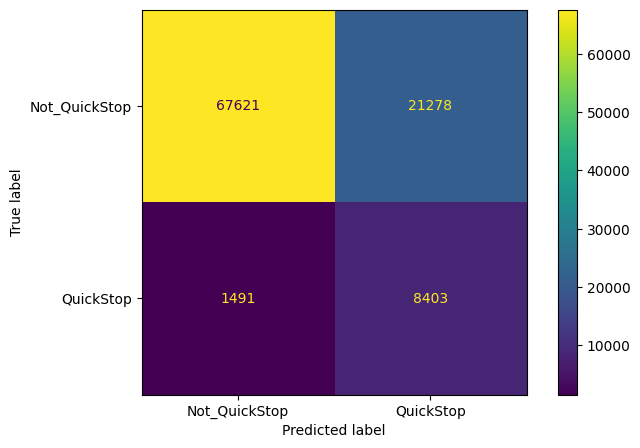

In [14]:
#confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = sk.metrics.ConfusionMatrixDisplay(sk.metrics.confusion_matrix(qs_y, qs_pred), display_labels = ['Not_QuickStop', 'QuickStop'])
cmp.plot(ax=ax)
plt.show()

C:\Users\kanev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


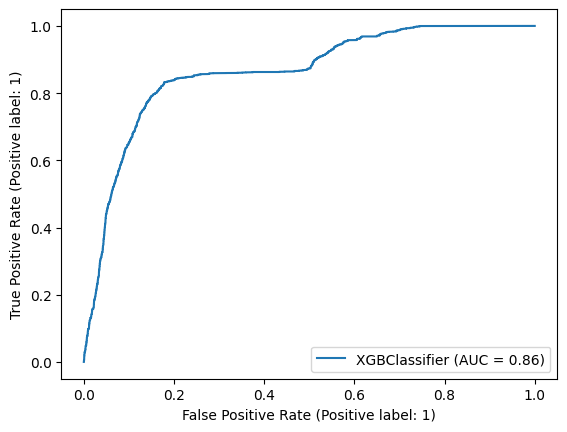

In [15]:
#auc roc plot
sk.metrics.plot_roc_curve(qs_model, qs_x, qs_y)
plt.show()

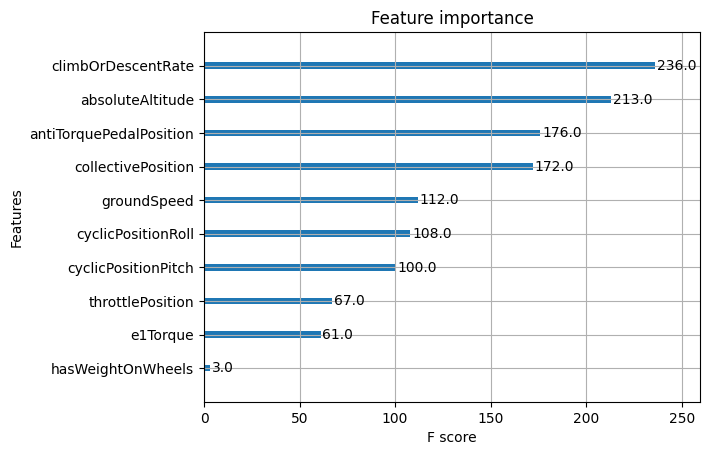

In [16]:
plot_importance(qs_model)
plt.show()

# Hover Taxi Model Validation Results

In [17]:
hover_x = v_df9[model_features]
hover_y = v_df9['Hover_Taxi']

In [18]:
filename = 'final_hover_model.pkl'
hover_model = pickle.load(open(filename, 'rb'))

In [19]:
hover_pred = hover_model.predict(hover_x)

In [20]:
hover_acc = sk.metrics.accuracy_score(hover_y, hover_pred)
hover_acc

0.9178787970807648

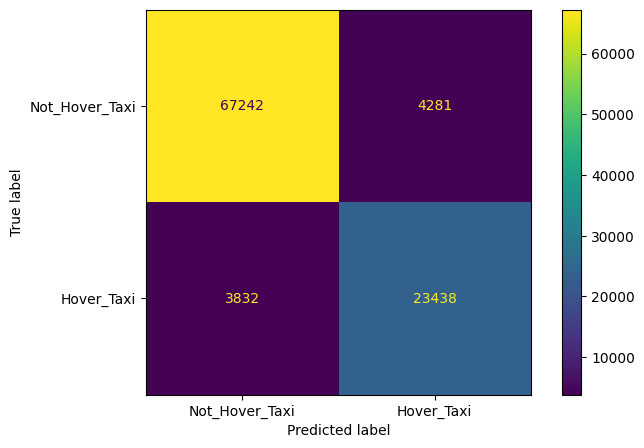

In [21]:
#confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = sk.metrics.ConfusionMatrixDisplay(sk.metrics.confusion_matrix(hover_y, hover_pred), display_labels = ['Not_Hover_Taxi', 'Hover_Taxi'])
cmp.plot(ax=ax)
plt.show()

C:\Users\kanev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


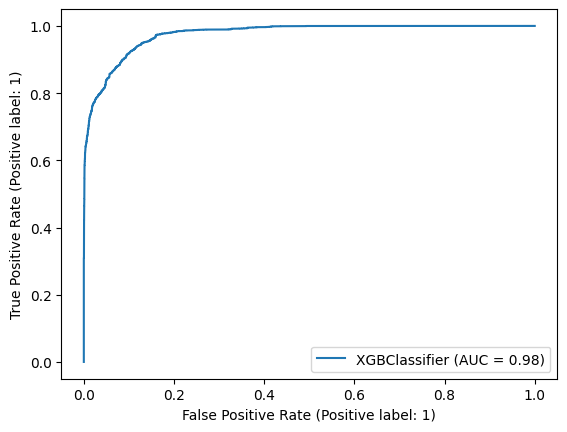

In [22]:
#auc roc plot
sk.metrics.plot_roc_curve(hover_model, hover_x, hover_y)
plt.show()

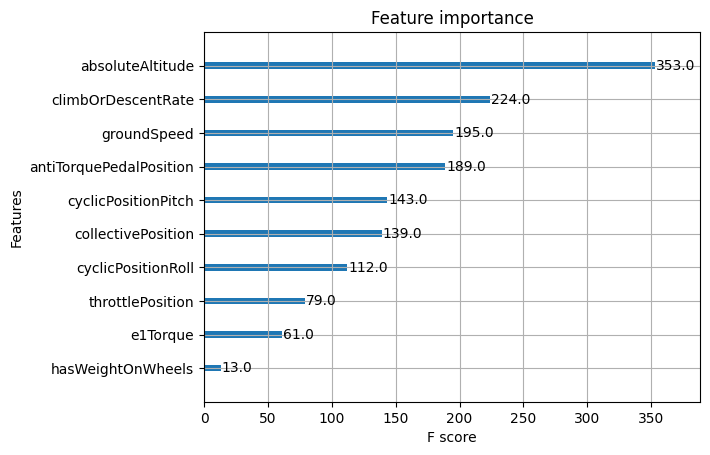

In [23]:
plot_importance(hover_model)
plt.show()

# Surface Taxi Model Validation Results

In [24]:
surface_x = v_df10[model_features]
surface_y = v_df10['Surface_Taxi']

In [25]:
filename = 'final_surface_model.pkl'
surface_model = pickle.load(open(filename, 'rb'))

In [26]:
surface_pred = surface_model.predict(surface_x)

In [27]:
surface_acc = sk.metrics.accuracy_score(surface_y, surface_pred)
surface_acc

0.9660589361435652

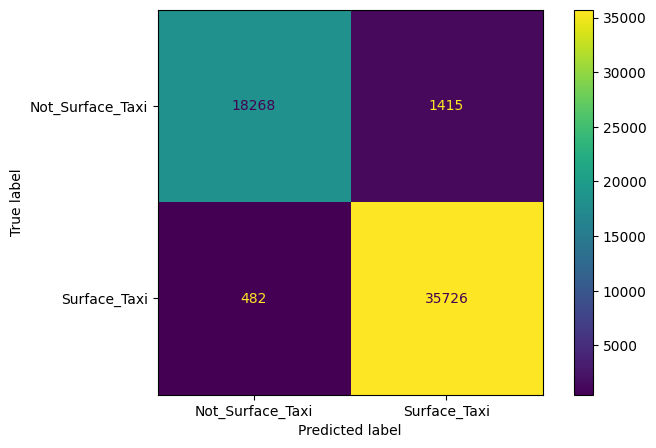

In [28]:
#confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = sk.metrics.ConfusionMatrixDisplay(sk.metrics.confusion_matrix(surface_y, surface_pred), display_labels = ['Not_Surface_Taxi', 'Surface_Taxi'])
cmp.plot(ax=ax)
plt.show()

C:\Users\kanev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


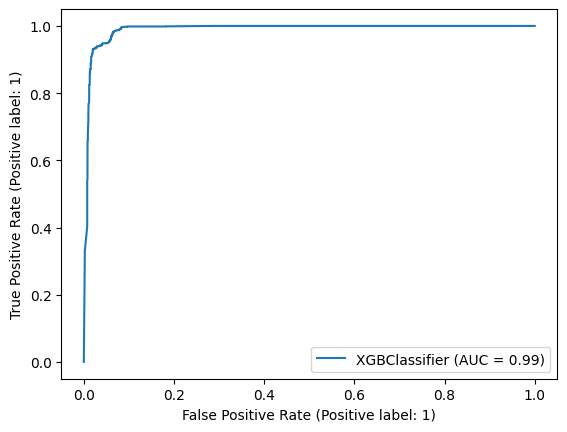

In [29]:
#auc roc plot
sk.metrics.plot_roc_curve(surface_model, surface_x, surface_y)
plt.show()

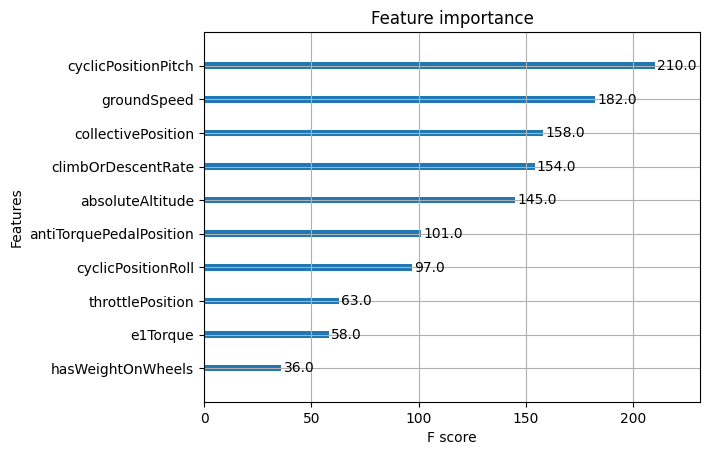

In [30]:
plot_importance(surface_model)
plt.show()

In [67]:
df_acc = pd.DataFrame([['Surface Taxi', "%.2f%%" % (100 * surface_acc)],['Hover Taxi', "%.2f%%" % (100 * hover_acc)],['Quick Stop', "%.2f%%" % (100 * qs_acc)]], columns = ['Model','Accuracy'])
print(df_acc.to_string(index=False))

       Model Accuracy
Surface Taxi   96.61%
  Hover Taxi   91.79%
  Quick Stop   76.95%
